# LAB 02 - Weather of Urbana

---
embed-resources: true
---

## Introduction

In this report, we develop a model to estimate when the Market at the Square should move indoors in 2025 as winter approaches. The model uses historical weather data, including average temperatures and precipitation trends, to recommend an optimal timeframe for the transition. While the model provides a data-driven guideline, it does not account for unexpected weather events or operational logistics, which should also be considered when making the final decision.

## Methods

In [1]:
# basic imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# machine learning imports
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import root_mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Data

In [2]:
# load data
weather_train = pd.read_parquet(
    "https://cs307.org/lab/data/weather-train.parquet",
)
weather_vtrain = pd.read_parquet(
    "https://cs307.org/lab/data/weather-vtrain.parquet",
)
weather_validation = pd.read_parquet(
    "https://cs307.org/lab/data/weather-validation.parquet",
)
weather_test = pd.read_parquet(
    "https://cs307.org/lab/data/weather-test.parquet",
)

The train data contains one row per day from the weather_train dataset.
The validation-train data contains one row per day from the weather_vtrain dataset.
The validation data contains one row per day from the weather_validation dataset.
The test data contains one row per day from the weather_test dataset.

The variables considered are:

#### Response

**`temperature_2m_min`**

- `[float64]` Minimum daily temperature in degrees Celsius recorded at 2 meters above ground level.

#### Features

`year`

- `[int64]` Year of the recorded temperature.

`day_of_year`

- `[int64]` The sequential day of the year, where January 1 is day 1 and December 31 is day 365 (or 366 for leap years).

In [3]:
weather_train.head()

,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2016-01-01,-4.2715,2016,1,1,1
2016-01-02,-3.8715,2016,1,2,2
2016-01-03,-4.4715,2016,1,3,3
2016-01-04,-3.0215,2016,1,4,4
2016-01-05,-5.7715,2016,1,5,5


In [4]:
weather_test.head()

,temperature_2m_min,year,month,day,day_of_year
date,,,,,
2023-01-01,1.998,2023,1,1,1
2023-01-02,7.498,2023,1,2,2
2023-01-03,9.748,2023,1,3,3
2023-01-04,1.398,2023,1,4,4
2023-01-05,0.948,2023,1,5,5


In [5]:
# summary statistics
stats_per_year = {}

for year in weather_train["year"].unique():

    year_data = weather_train[weather_train["year"] == year]
    days_count = len(year_data)
    mean_temp = year_data["temperature_2m_min"].mean() 
    std_temp = year_data["temperature_2m_min"].std() 

    stats_per_year[year] = {
        "Days": days_count,
        "Mean Temperature": mean_temp,
        "Std Temperature": std_temp
    }

for year, stats in stats_per_year.items():
    print(f"Year {year}: {stats['Days']} days, Mean Min Temp: {stats['Mean Temperature']}, Std Min Temp: {stats['Std Temperature']}")

Year 2016: 366 days, Mean Min Temp: 8.793391227722168, Std Min Temp: 10.274505615234375
Year 2017: 365 days, Mean Min Temp: 8.399643898010254, Std Min Temp: 9.692304611206055
Year 2018: 365 days, Mean Min Temp: 7.591012954711914, Std Min Temp: 11.369451522827148
Year 2019: 365 days, Mean Min Temp: 7.229781150817871, Std Min Temp: 10.882259368896484
Year 2020: 366 days, Mean Min Temp: 7.684611797332764, Std Min Temp: 9.38359260559082
Year 2021: 365 days, Mean Min Temp: 8.119369506835938, Std Min Temp: 10.38848876953125
Year 2022: 365 days, Mean Min Temp: 7.010191917419434, Std Min Temp: 11.028169631958008


We see that 2022 had the lowest mean temperature and that 2016 had the highest mean temperature. In addition, we can observe that 2020 has the lowest variability in temperatures while 2018 had the highest.

In [6]:
import calendar

stats_per_month = {}

for month in weather_train["month"].unique():

    month_data = weather_train[weather_train["month"] == month]
    mean_temp = month_data["temperature_2m_min"].mean()
    std_temp = month_data["temperature_2m_min"].std() 

    stats_per_month[month] = {
        "Mean Temperature": mean_temp,
        "Std Temperature": std_temp
    }

for month, stats in stats_per_month.items():
    month_name = calendar.month_name[month]
    print(f"Month {month_name}: Mean Min Temp: {stats['Mean Temperature']}, Std Min Temp: {stats['Std Temperature']}")

Month January: Mean Min Temp: -5.416767120361328, Std Min Temp: 6.54742956161499
Month February: Mean Min Temp: -4.380612850189209, Std Min Temp: 6.746121406555176
Month March: Mean Min Temp: 1.5221726894378662, Std Min Temp: 5.595674514770508
Month April: Mean Min Temp: 5.925213813781738, Std Min Temp: 5.65961217880249
Month May: Mean Min Temp: 12.639453887939453, Std Min Temp: 5.234889984130859
Month June: Mean Min Temp: 18.21140480041504, Std Min Temp: 3.5402793884277344
Month July: Mean Min Temp: 19.99820899963379, Std Min Temp: 2.627939462661743
Month August: Mean Min Temp: 19.088069915771484, Std Min Temp: 2.8746023178100586
Month September: Mean Min Temp: 16.57164192199707, Std Min Temp: 3.9883968830108643
Month October: Mean Min Temp: 9.756274223327637, Std Min Temp: 5.775242328643799
Month November: Mean Min Temp: 1.8883094787597656, Std Min Temp: 5.663248062133789
Month December: Mean Min Temp: -2.51469349861145, Std Min Temp: 5.680539608001709


We can observe that January has the lowest average temperature with -5.41678 degrees celcius and that July has the highest average temperature with 19.998 degrees celcius.

/var/folders/b8/k6v1k2b945jddf5qjvdvfqwh0000gn/T/ipykernel_43587/2119092660.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=weather_combined, x="year", y="temperature_2m_min", palette="viridis")


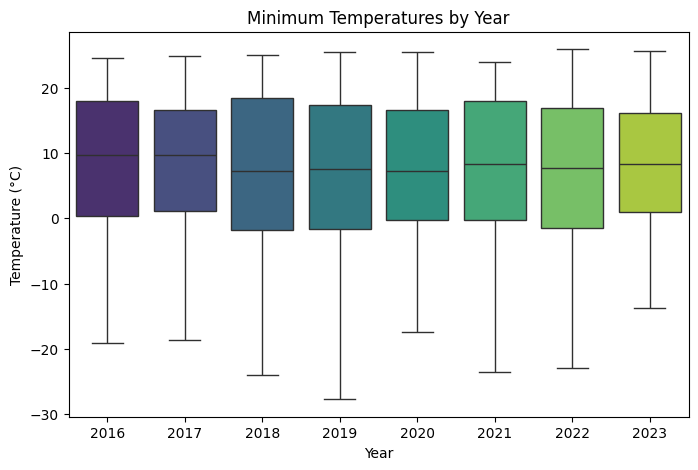

In [7]:
# exploratory visualization
weather_combined = pd.concat([weather_train, weather_vtrain, weather_validation, weather_test])

plt.figure(figsize=(8, 5))
sns.boxplot(data=weather_combined, x="year", y="temperature_2m_min", palette="viridis")
plt.title("Minimum Temperatures by Year")
plt.xlabel("Year")
plt.ylabel("Temperature (°C)")
plt.show()

The above visualization shows the variance of the minimum temperatures in all the years recorded in the dataset. These box-and-whisker plots allow for easy comparison of year-to-year temperature patterns and highlight any anomalies or trends. Across the years, the median minimum temperature remains fairly consistent, but there is notable variability in the spread of temperatures, particularly in 2019 and 2020, where the range is slightly broader. Outliers are minimal, suggesting that extreme temperature events are uncommon in this dataset.

### Models

In [8]:
# create X and y for train
X_train = weather_train[["year", "day_of_year"]]
y_train = weather_train["temperature_2m_min"]

# create X and y for validation-train
X_vtrain = weather_vtrain[["year", "day_of_year"]]
y_vtrain = weather_vtrain["temperature_2m_min"]

# create X and y for validation
X_validation = weather_validation[["year", "day_of_year"]]
y_validation = weather_validation["temperature_2m_min"]

# create X and y for test
X_test = weather_test[["year", "day_of_year"]]
y_test = weather_test["temperature_2m_min"]

In [9]:
samples, features = X_train.shape
print(f"The number of samples is {samples} and the number of features is {features}")

The number of samples is 2557 and the number of features is 2


In [10]:
# try many values of k for knn
val_rmse_values = []
k_to_try = [1, 5, 10, 25, 50, 100, 250, 500]
for k in k_to_try:
    knn = KNeighborsRegressor(
        n_neighbors=k,
        p=1,  # manhattan distance via minkowski with p=1
    )
    knn.fit(X_vtrain, y_vtrain)
    pred = knn.predict(X_validation)
    val_rmse = root_mean_squared_error(y_validation, pred)
    val_rmse_values.append(val_rmse)

In [11]:
# get best validation k and rmse
knn_k_best = k_to_try[np.argmin(val_rmse_values)]
knn_val_rmse_best = min(val_rmse_values)

# refit to full train data
mod = KNeighborsRegressor(
    n_neighbors=knn_k_best,
    p=1,
)
mod.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=100, p=1)

We consider a single untuned model, a k-nearest neighbors regressor.

## Results

In [12]:
# report model metrics - calculate test RMSE
pred = mod.predict(X_test)
knn_test_rmse = root_mean_squared_error(y_test, pred)

print(f"The RMSE of the test set: {knn_test_rmse}")

The RMSE of the test set: 4.725839138031006


The selected model achieves a test RMSE of 4.725839

In [13]:
# summary figure
mae = mean_absolute_error(y_test, pred)
mse = mean_squared_error(y_test, pred)
rmse = mean_squared_error(y_test, pred)
r2 = r2_score(y_test, pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 3.72
Mean Squared Error (MSE): 22.33
Root Mean Squared Error (RMSE): 22.33
R² Score: 0.71


The Mean Absolute Error (MAE) of 3.72 indicates that, on average, the model's predictions deviate from the actual values by approximately 3.72 units. The Mean Squared Error (MSE) is 22.33, which measures the average squared difference between predicted and actual values, heavily penalizing larger errors. The Root Mean Squared Error (RMSE), also 22.33, provides a similar metric but in the same unit as the target variable, showing the model's average prediction error. Finally, the R² Score of 0.71 indicates that 71% of the variance in the target variable is explained by the model, suggesting it has a decent fit but leaves room for improvement.

In [14]:
# serialize model
from joblib import dump
dump(mod, "weather.joblib")

['weather.joblib']

## Discussion

While the model's performance, with an R² score of 0.71, demonstrates a decent fit and explains a significant portion of the variance in minimum temperatures, its usefulness remains limited without further validation. Metrics like RMSE (22.33) and MAE (3.72) provide valuable insights into the model's overall error but fail to address the specific contexts in which the model’s predictions will be used. For example, an underestimation or overestimation of extreme temperature values could have significant implications for the timing of decisions, such as moving the market indoors.

The primary limitation lies in the model's inability to communicate uncertainty or confidence in its predictions. Predicting a minimum temperature of -5°C versus -15°C both suggest cold weather, but they imply very different operational decisions. Accurately capturing and communicating the range of uncertainty in predictions is critical for practical decision-making, such as adjusting market operations in response to early or late seasonal temperature changes.

Additionally, the model could likely be improved by incorporating more contextual and environmental features. Inputs such as daily precipitation, wind chill, and long-term weather trends could enhance its accuracy. Furthermore, the model assumes that historical weather patterns (2016–2023) will hold in 2025, which is not guaranteed. Climate change and other factors could shift these patterns, potentially reducing the reliability of the model's predictions for future years.

Lastly, while the model captures general seasonal trends, it must be validated against specific operational thresholds relevant to decision-making, such as the temperature thresholds at which outdoor operations become infeasible. For example, while the model’s predictions align with expected seasonal trends (e.g., lower temperatures in winter), further analysis is needed to confirm that these predictions align with actionable thresholds for the City of Urbana.

The following graphic provides minimal validation of the model's internal consistency. For example, we observe clear seasonal patterns in minimum temperatures, with lower values occurring during colder months as expected. However, further evaluation is necessary to determine the accuracy and relevance of these predictions in real-world operational contexts.